<a href="https://colab.research.google.com/github/Meenakshi-152/text-to-speech/blob/main/SpeechT5model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the requirements

In [ ]:
!pip install datasets soundfile speechbrain
!pip install git+https://github.com/huggingface/transformers.git
!pip install --upgrade accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.2/807.2 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 31.1 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-powmpmiz
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-powmpmiz
  Resolved https://github.com/huggingface/transformers.git to commit c42b3223db0fc24ff9a694f19e6c78faf3ac58a1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata

Install the required Librarires.

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
from datasets import load_dataset, Audio
import re
import os
import torch
from speechbrain.pretrained import EncoderClassifier
import matplotlib.pyplot as plt
from transformers import SpeechT5HifiGan
from IPython.display import Audio
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from huggingface_hub import notebook_login
from functools import partial
from transformers import Seq2SeqTrainer
from IPython.display import Audio
import soundfile as sf

<ipython-input-2-2be2bd750e68>:6: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


Load SpeechT5 and fine-tune it again but for English technical words.

In [ ]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

Load the data set [here](https://huggingface.co/datasets/Yassmen/TTS_English_Technical_data)

In [ ]:
dataset = load_dataset(
    "Yassmen/TTS_English_Technical_data", split="train"
)

README.md:   0%|          | 0.00/333 [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/469M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/466M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/541M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9951 [00:00<?, ? examples/s]

Set the sampling rate of the audio data to 16 kHz, as SpeechT5 expects.

In [ ]:
from datasets import Audio
import torch
import torchaudio

# Step 1: Cast the audio column (without sampling_rate)
dataset = dataset.cast_column("audio", Audio())

# Step 2: Resample audio function
def resample_audio(example):
    # Retrieve the sampling rate of the example
    sampling_rate = example['audio']['sampling_rate']

    # Only resample if the original sampling rate is different from the target
    if sampling_rate != 16000:
        # Convert NumPy array to a PyTorch tensor
        audio_tensor = torch.tensor(example["audio"]["array"], dtype=torch.float32)

        # Apply the resampler
        resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
        resampled_audio = resampler(audio_tensor)

        # Update the example with the resampled audio and new sampling rate
        example["audio"]["array"] = resampled_audio.numpy()  # Convert back to NumPy array
        example["audio"]["sampling_rate"] = 16000  # Update the sampling rate

    return example

# Step 3: Apply the resampling function to the dataset
dataset = dataset.map(resample_audio)


Map:   0%|          | 0/9951 [00:00<?, ? examples/s]

In [ ]:
len(dataset)

9951

Clean the Text


In [ ]:
tokenizer = processor.tokenizer

In [ ]:
def extract_all_chars(batch):
    all_text = " ".join(batch["transcription"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/9951 [00:00<?, ? examples/s]

Find the difference between the text which are in the model but not in the tokenizer.

In [ ]:
dataset_vocab - tokenizer_vocab

{'\n',
 ' ',
 '$',
 '%',
 '&',
 '*',
 '+',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '@',
 '_',
 '\xa0',
 '’',
 '“',
 '”'}

Normalizing the dataset


In [ ]:
def normalize_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation (except apostrophes)
    text = re.sub(r'[^\w\s\']', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

Define a function to add the normalized_text column

In [ ]:
def add_normalized_text(example):
    example['normalized_text'] = normalize_text(example['transcription'])
    return example

Apply the function to the dataset

In [ ]:
dataset = dataset.map(add_normalized_text)

Map:   0%|          | 0/9951 [00:00<?, ? examples/s]

Print the first few examples to verify

In [ ]:
print(dataset[2:5])

{'audio': [{'path': None, 'array': array([-0.00543213,  0.02911377, -0.02990723, ..., -0.07556152,
       -0.07019043, -0.07574463]), 'sampling_rate': 16000}, {'path': None, 'array': array([0.00036621, 0.00485229, 0.0105896 , ..., 0.01382446, 0.01513672,
       0.00439453]), 'sampling_rate': 16000}, {'path': None, 'array': array([ 0.14535522,  0.14434814,  0.06204224, ..., -0.03033447,
       -0.04058838, -0.04193115]), 'sampling_rate': 16000}], 'transcription': ["Twilio does have one of\nthose but if you were looking at one of these that didn't,", "plus 3 and so it's just basically it continues the generation in all the", 'There are people, you\nmight not think about this, but there are people who are\ngoing to use your application'], 'normalized_text': ["twilio does have one of those but if you were looking at one of these that didn't", "plus 3 and so it's just basically it continues the generation in all the", 'there are people you might not think about this but there are people who

In [ ]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

Map:   0%|          | 0/9951 [00:00<?, ? examples/s]

In [ ]:
dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

In [ ]:
dataset_vocab - tokenizer_vocab

{' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '_'}

##Speaker Embedding

Create the speaker embeddings, using the [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb) model from SpeechBrain. The `create_speaker_embedding()` defines a function which takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [ ]:
spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)

hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

In [ ]:
def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

Preparing the dataset


In [ ]:
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Verifying the process is correct

In [ ]:
processed_example = prepare_dataset(dataset[0])

In [ ]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [ ]:
tokenizer.decode(processed_example["input_ids"])

'so this point one i just guessed it so one question is how do you determine</s>'

Checking the shape of Speaker embeddings

In [ ]:
processed_example["speaker_embeddings"].shape

(512,)

The labels should be a log-mel spectrogram with 80 mel bins.

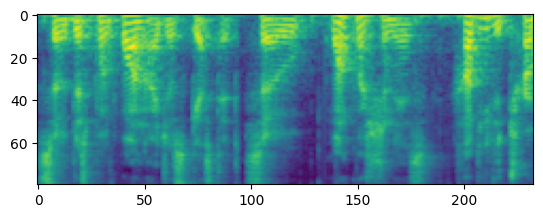

In [ ]:
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

If the vocoder is run on the log-mel spectrogram, it should produce the original audio again. Load the HiFi-GAN vocoder from the original [SpeechT5 checkpoint](https://hf.co/microsoft/speecht5_hifigan).

In [ ]:
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [ ]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

In [ ]:
dataset = dataset.map(
    prepare_dataset, remove_columns=dataset.column_names,
)

Map:   0%|          | 0/9951 [00:00<?, ? examples/s]

Remove Long Inputs

In [ ]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])

Filter:   0%|          | 0/9951 [00:00<?, ? examples/s]

Checking the length after the removal

In [ ]:
len(dataset)

9927

## Train/Test split

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 8934
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 993
    })
})

Define a custom collator to combine multiple examples into a batch.


In [ ]:
@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

Test the data collator.

In [ ]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [ ]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 108]),
 'attention_mask': torch.Size([3, 108]),
 'labels': torch.Size([3, 358, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

## Training

In [ ]:
notebook_login()

Disable cache during training since it's incompatible with gradient checkpointing

In [ ]:
model.config.use_cache = False

Set language and task for generation and re-enable cache

In [ ]:
model.generate = partial(model.generate, use_cache=True)

Define the training arguments.

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_meenakshiTTS",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-4,
    warmup_steps=100,
    max_steps=500,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=100,
    eval_steps=100,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Create the trainer object using the model, dataset, and data collator.

In [ ]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

<ipython-input-41-fdc3559dc356>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
max_steps is given, it will override any value given in num_train_epochs


##Training
Start Training

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
100,4.634400,0.515010
200,4.366800,0.489785
300,4.130400,0.471295
400,3.984300,0.460025
500,3.937500,0.455282


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2816: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/usr/local/lib/python3.10

TrainOutput(global_step=500, training_loss=4.430616119384766, metrics={'train_runtime': 1282.879, 'train_samples_per_second': 12.472, 'train_steps_per_second': 0.39, 'total_flos': 1303814407094496.0, 'train_loss': 4.430616119384766, 'epoch': 1.7905102954341987})

In [ ]:
kwargs = {
    "dataset_tags": "microsoft/speecht5_tts",
    "dataset": "TTS_English_Technical_data",  # a name for the training dataset
    "dataset_args": "split: train",
    "model_name": "SpeechT5 Technical English",  # a name for your model
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
    "tags": "tts",
}

Execute the `push_to_hub` command for the training results to be uploaded to the Hub.

In [ ]:
trainer.push_to_hub(**kwargs)

CommitInfo(commit_url='https://huggingface.co/Meen15kshi/speecht5_finetuned_meenakshiTTS/commit/d56bd178c1f3524402d98f32873351c0ce2668ed', commit_message='End of training', commit_description='', oid='d56bd178c1f3524402d98f32873351c0ce2668ed', pr_url=None, pr_revision=None, pr_num=None)

Upload the Model from Hugging Face Hub, and use it to Synthesis speech.

In [ ]:
model = SpeechT5ForTextToSpeech.from_pretrained("Meen15kshi/speecht5_finetuned_meenakshiTTS")

config.json:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Check for the test set.

In [ ]:
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

Tokenize the inputs

In [ ]:
text = "Hello, this is a design of RESTful API for a machine learning?"

num2words
is used to change the numbers to words in the input text

In [ ]:
inputs = processor(text=text, return_tensors="pt")

Generate a spectrogram from the input text.

In [ ]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

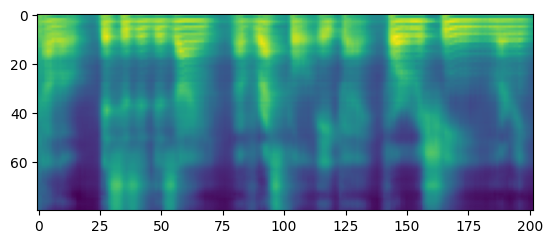

In [ ]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

Turn the spectrogram into sound.

In [ ]:
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

Download the generated text to speech audio


In [ ]:
sf.write("output.wav", speech.numpy(), samplerate=16000)